In [ ]:
# default_exp callback.MVP

# MVP (aka TSBERT): Self-Supervised Pretraining of Time Series Models

> Masked Value Predictor callback used to predict time series step values after a binary mask has been applied.

This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on:

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). [A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.](https://arxiv.org/pdf/2010.02803). No official implementation available as far as I know (Oct 10th, 2020)

In [ ]:
#export
from fastai.callback.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.models.utils import *
from tsai.models.layers import *

In [ ]:
#export
from torch.distributions.beta import Beta

In [ ]:
#export
def create_subsequence_mask(o, r=.15, lm=3, stateful=True, sync=False):
    if o.ndim == 2: o = o[None]
    n_masks, mask_dims, mask_len = o.shape
    if sync == 'random': sync = random.random() > .5
    dims = 1 if sync else mask_dims
    numels = n_masks * dims * mask_len
    pm = 1 / lm
    pu = np.clip(pm * (r / max(1e-6, 1 - r)), 1e-3, 1)
    a, b, proba_a, proba_b = ([1], [0], pu, pm) if random.random() > pm else ([0], [1], pm, pu)
    if stateful: 
        max_len = max(1, 2 * math.ceil(numels // (1/pm + 1/pu)))
        for i in range(10):
            _dist_a = np.random.geometric(proba_a, max_len)
            _dist_b = np.random.geometric(proba_b, max_len)
            dist_a = _dist_a if i == 0 else np.concatenate((dist_a, _dist_a), axis=-1)
            dist_b = _dist_b if i == 0 else np.concatenate((dist_b, _dist_b), axis=-1)
            if (dist_a + dist_b).sum() >= numels:
                break
            else:
                max_len *= 2
        dist_len = np.argmax((dist_a + dist_b).cumsum() >= numels) + 1
        l = [a*ax + b*bx for (ax, bx) in zip(dist_a[:dist_len], dist_b[:dist_len])]
        _mask = list(itertools.chain.from_iterable(l))[:numels]
        mask = o.new(_mask).reshape(n_masks, dims, mask_len)
    else: 
        mask = o.new(np.random.binomial(1, 1 - r, (n_masks, dims, mask_len))) # faster than torch.distributions.binomial.Binomial
    if sync: mask = mask.repeat(1, mask_dims, 1)
    return mask

def create_variable_mask(o, r=.15):
    n_masks, mask_dims, mask_len = o.shape
    _mask = np.ones((n_masks * mask_dims, mask_len))
    if int(mask_dims * r) > 0:
        n_masked_vars = int(n_masks * mask_dims * r)
        sel_dims = np.random.choice(n_masks * mask_dims, n_masked_vars, False)
        _mask[sel_dims] = 0
    mask = o.new(_mask).reshape(*o.shape)
    return mask

def create_future_mask(o, r=.15, sync=False):
    if o.ndim == 2: o = o[None]
    n_masks, mask_dims, mask_len = o.shape
    if sync == 'random': sync = random.random() > .5
    if sync:
        sel_steps = int(round(mask_len * r))
        _mask = np.ones((1, 1, mask_len))
        _mask[..., -sel_steps:] = 0
        mask = o.new(_mask).repeat(n_masks, mask_dims, 1)
    else:
        _mask = np.ones((n_masks, mask_dims, mask_len))
        for i in range(n_masks):
            for j in range(mask_dims):
                steps = int(np.random.uniform(0, 2*r*mask_len))
                if steps == 0: continue
                _mask[i, j, -steps:] = 0
    mask = o.new(_mask)
    return mask

In [ ]:
t = torch.rand(16, 3, 100)
mask = create_subsequence_mask(t, sync=False)
test_eq(mask.shape, t.shape)
mask = create_subsequence_mask(t, sync=True)
test_eq(mask.shape, t.shape)
mask = create_variable_mask(t)
test_eq(mask.shape, t.shape)
mask = create_future_mask(t)
test_eq(mask.shape, t.shape)

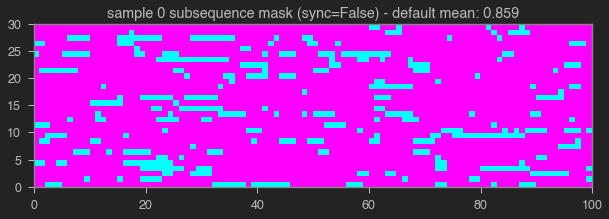

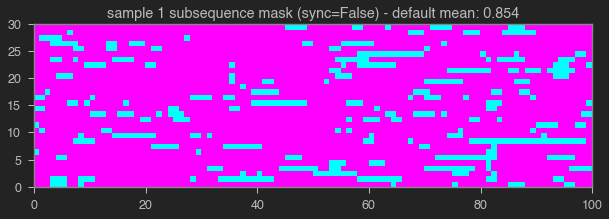

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, r=.15)# default settings
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'sample 0 subsequence mask (sync=False) - default mean: {mask[0].mean().item():.3f}')
plt.show()
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[1], cmap='cool')
plt.title(f'sample 1 subsequence mask (sync=False) - default mean: {mask[1].mean().item():.3f}')
plt.show()

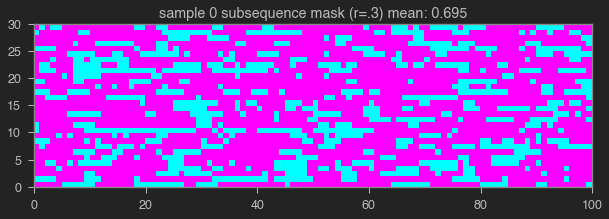

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, r=.3)# 30% of values masked
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'sample 0 subsequence mask (r=.3) mean: {mask[0].mean().item():.3f}')
plt.show()

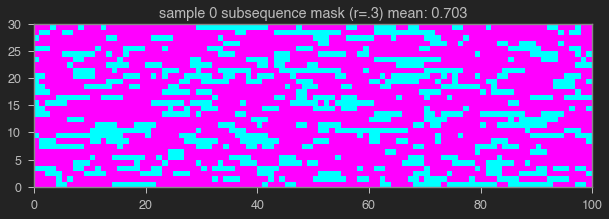

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, r=.30)# 30% of values masked
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'sample 0 subsequence mask (r=.3) mean: {mask[0].mean().item():.3f}')
plt.show()

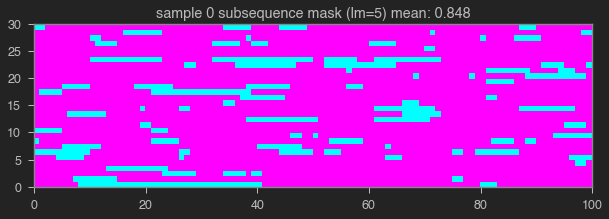

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, lm=5)# average length of mask = 5 
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'sample 0 subsequence mask (lm=5) mean: {mask[0].mean().item():.3f}')
plt.show()

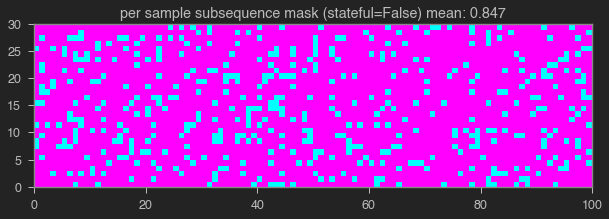

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, stateful=False)# individual time steps masked 
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'per sample subsequence mask (stateful=False) mean: {mask[0].mean().item():.3f}')
plt.show()

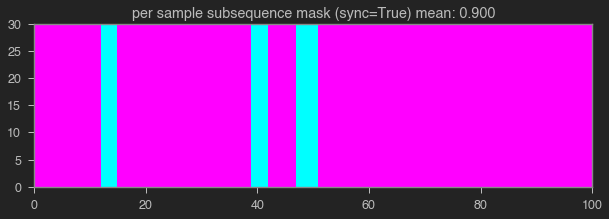

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_subsequence_mask(t, sync=True)# all time steps masked simultaneously
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'per sample subsequence mask (sync=True) mean: {mask[0].mean().item():.3f}')
plt.show()

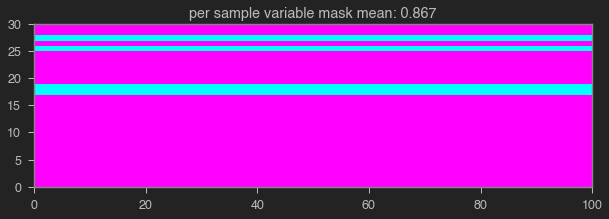

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_variable_mask(t)# masked variables
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'per sample variable mask mean: {mask[0].mean().item():.3f}')
plt.show()

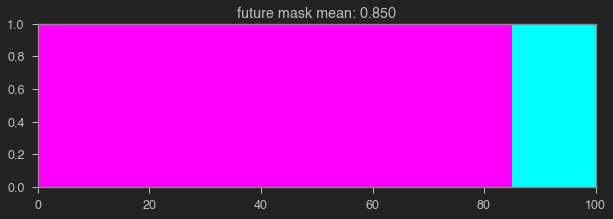

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_future_mask(t, r=.15, sync=True)# masked steps
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'future mask mean: {mask[0].mean().item():.3f}')
plt.show()

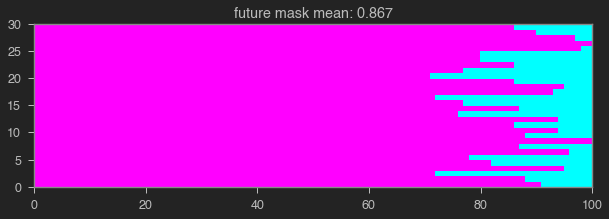

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_future_mask(t, r=.15, sync=False)# masked steps
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title(f'future mask mean: {mask[0].mean().item():.3f}')
plt.show()

In [ ]:
#export
def create_mask(o,  r=.15, lm=3, stateful=True, sync=False, subsequence_mask=True, variable_mask=False, future_mask=False, custom_mask=None):
    if r <= 0 or r >=1: 
        return torch.ones_like(o)
    if int(r * o.shape[1]) == 0:
        variable_mask = False 
    if subsequence_mask and variable_mask:
        random_thr = 1/3 if sync == 'random' else 1/2
        if random.random() > random_thr: 
            variable_mask = False
        else:
            subsequence_mask = False 
    if custom_mask is not None:
        return custom_mask(o)
    elif future_mask:
        return create_future_mask(o, r=r)
    elif subsequence_mask:
        return create_subsequence_mask(o, r=r, lm=lm, stateful=stateful, sync=sync)
    elif variable_mask:
        return create_variable_mask(o, r=r)
    else:
        raise ValueError('You need to set subsequence_mask, variable_mask or future_mask to True or pass a custom mask.')

In [ ]:
#export
class MVP_Loss(Module):
    def __init__(self, crit=None):
        self.crit = ifnone(crit, MSELossFlat())
        self.mask = slice(None)
        
    def forward(self, preds, target):
        return self.crit(preds[self.mask], target[self.mask])
    
TSBERT_Loss = MVP_Loss

In [ ]:
# export
import matplotlib.colors as mcolors


class MVP(Callback):
    order = 60

    def __init__(self, r: float = .15, subsequence_mask: bool = True, lm: float = 3., stateful: bool = True, sync: bool = False, variable_mask: bool = False,
                 future_mask: bool = False, custom_mask: Optional = None, dropout: float = .1, crit: callable = None,
                 target_dir: str = './data/MVP', fname: str = 'model', save_best: bool = True, save_model: bool = True, verbose: bool = False): 
        r"""
        Callback used to perform the pretext task of reconstruct the original data after a binary mask has been applied.

        Args:
            r: proba of masking.
            subsequence_mask: apply a mask to random subsequences.
            lm: average mask len when using stateful (geometric) masking.
            stateful: geometric distribution is applied so that average mask length is lm.
            sync: all variables have the same masking.
            variable_mask: apply a mask to random variables. Only applicable to multivariate time series.
            future_mask: used to train a forecasting model.
            custom_mask: allows to pass any type of mask with input tensor and output tensor.
            dropout: dropout applied to the head of the model during pretraining.
            crit: loss function that will be used. If None MSELossFlat().
            target_dir : directory where trained model will be stored.
            fname : file name that will be used to save the pretrained model.
            save_best: saves best model weights
            save_model: saves both state_dict() and model when True. If False, only state_dict() is saved.
    """
        assert subsequence_mask or variable_mask or future_mask or custom_mask, \
            'you must set (subsequence_mask and/or variable_mask) or future_mask to True or use a custom_mask'
        if custom_mask is not None and (future_mask or subsequence_mask or variable_mask):
            warnings.warn("Only custom_mask will be used")
        elif future_mask and (subsequence_mask or variable_mask):
            warnings.warn("Only future_mask will be used")
        store_attr("subsequence_mask,variable_mask,future_mask,custom_mask,dropout,r,lm,stateful,sync,crit,fname,save_best,save_model,verbose")
        self.PATH = Path(f'{target_dir}/{self.fname}')
        if not os.path.exists(self.PATH.parent):
            os.makedirs(self.PATH.parent)
        if save_model:
            self.path_text = f"pretrained model_path='{self.PATH}_model.pth'; weights_path='{self.PATH}.pth'"
        else:
            self.path_text = f"pretrained weights_path='{self.PATH}.pth'"
        

    def before_fit(self):
        self.run = not hasattr(self, "lr_finder") and not hasattr(
            self, "gather_preds")
        if not(self.run):
            return

        # prepare to save best model
        self.best = float('inf')

        # modify loss for denoising task
        self.old_loss_func = self.learn.loss_func
        self.learn.loss_func = MVP_Loss(self.crit)
        self.learn.MVP = self

        # remove and store metrics
        self.learn.metrics = L([])

        # change head with conv layer (equivalent to linear layer applied to dim=1)
        assert hasattr(self.learn.model, "head"), "model must have a head attribute to be trained with MVP"
        self.learn.model.head = nn.Sequential(nn.Dropout(self.dropout), 
                                              nn.Conv1d(self.learn.model.head_nf, self.learn.dls.vars, 1)).to(self.learn.dls.device)

    def before_batch(self):
        self.learn.yb = (self.x,)
        mask = create_mask(self.x,  r=self.r, lm=self.lm, stateful=self.stateful, sync=self.sync, subsequence_mask=self.subsequence_mask, 
                           variable_mask=self.variable_mask, future_mask=self.future_mask, custom_mask=self.custom_mask)
        self.learn.xb = (self.x * mask,)
        self.learn.loss_func.mask = (mask == 0)  # boolean mask
        self.mask = mask

    def after_epoch(self):
        val = self.learn.recorder.values[-1][-1]
        if self.save_best:
            if np.less(val, self.best): 
                self.best = val
                self.best_epoch = self.epoch
                if self.save_model:
                    torch.save(self.learn.model, f'{self.PATH}_model.pth')
                torch.save(self.learn.model.state_dict(), f'{self.PATH}.pth')
                pv(f"best epoch: {self.best_epoch:3}  val_loss: {self.best:8.6f} - {self.path_text}", self.verbose or (self.epoch == self.n_epoch - 1))
            elif self.epoch == self.n_epoch - 1:
                print(f"\nepochs: {self.n_epoch} best epoch: {self.best_epoch:3}  val_loss: {self.best:8.6f} - {self.path_text}\n")
        elif self.epoch == self.n_epoch - 1:
            if self.save_model:
                torch.save(self.learn.model, f'{self.PATH}_model.pth')
            torch.save(self.learn.model.state_dict(), f'{self.PATH}.pth')
            print(f"\nepoch: {self.epoch:3}  val_loss: {val:8.6f} - {self.path_text}\n")
            
    def after_fit(self):
        self.run = True

    def show_preds(self, max_n=9, nrows=3, ncols=3, figsize=None, sharex=True, **kwargs):
        b = self.learn.dls.valid.one_batch()
        self.learn._split(b)
        xb = self.xb[0].detach().cpu().numpy()
        bs, nvars, seq_len = xb.shape
        self.learn('before_batch')
        pred = self.learn.model(*self.learn.xb).detach().cpu().numpy()
        mask = self.mask.cpu().numpy()
        masked_pred = np.ma.masked_where(mask, pred)
        ncols = min(ncols, math.ceil(bs / ncols))
        nrows = min(nrows, math.ceil(bs / ncols))
        max_n = min(max_n, bs, nrows*ncols)
        if figsize is None:
            figsize = (ncols*6, math.ceil(max_n/ncols)*4)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                               figsize=figsize, sharex=sharex, **kwargs)
        idxs = np.random.permutation(np.arange(bs))
        colors = list(mcolors.TABLEAU_COLORS.keys()) + \
            random_shuffle(list(mcolors.CSS4_COLORS.keys()))
        i = 0
        for row in ax:
            for col in row:
                color_iter = iter(colors)
                for j in range(nvars):
                    try:
                        color = next(color_iter)
                    except:
                        color_iter = iter(colors)
                        color = next(color_iter)
                    col.plot(xb[idxs[i]][j], alpha=.5, color=color)
                    col.plot(masked_pred[idxs[i]][j],
                             marker='o', markersize=4, color=color)
                i += 1
        plt.tight_layout()
        plt.show()

TSBERT = MVP

# Experiments

In [ ]:
from fastai.data.transforms import *
from tsai.data.all import *
from tsai.models.utils import *
from tsai.models.layers import *
from tsai.learner import *
from tsai.models.TSTPlus import *
from tsai.models.InceptionTimePlus import *

In [ ]:
dsid = 'MoteStrain'
X, y, splits = get_UCR_data(dsid, split_data=False)
check_data(X, y, splits, False)

X      - shape: [1272 samples x 1 features x 84 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (1272,)  type: memmap  dtype:<U1  n_classes: 2 (636 samples per class) ['1', '2']  isnan: False
splits - n_splits: 2 shape: [20, 1252]  overlap: [False]


In [ ]:
# Pre-train
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
fname = f'{dsid}'
mvp = MVP(subsequence_mask=True, sync='random', variable_mask=True, fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=mvp) # Any metrics will be ignored!
learn.fit_one_cycle(1, 3e-3)

best epoch:   0  val_loss: 1.008286 - pretrained model_path='data/MVP/MoteStrain_model.pth'; weights_path='data/MVP/MoteStrain.pth'


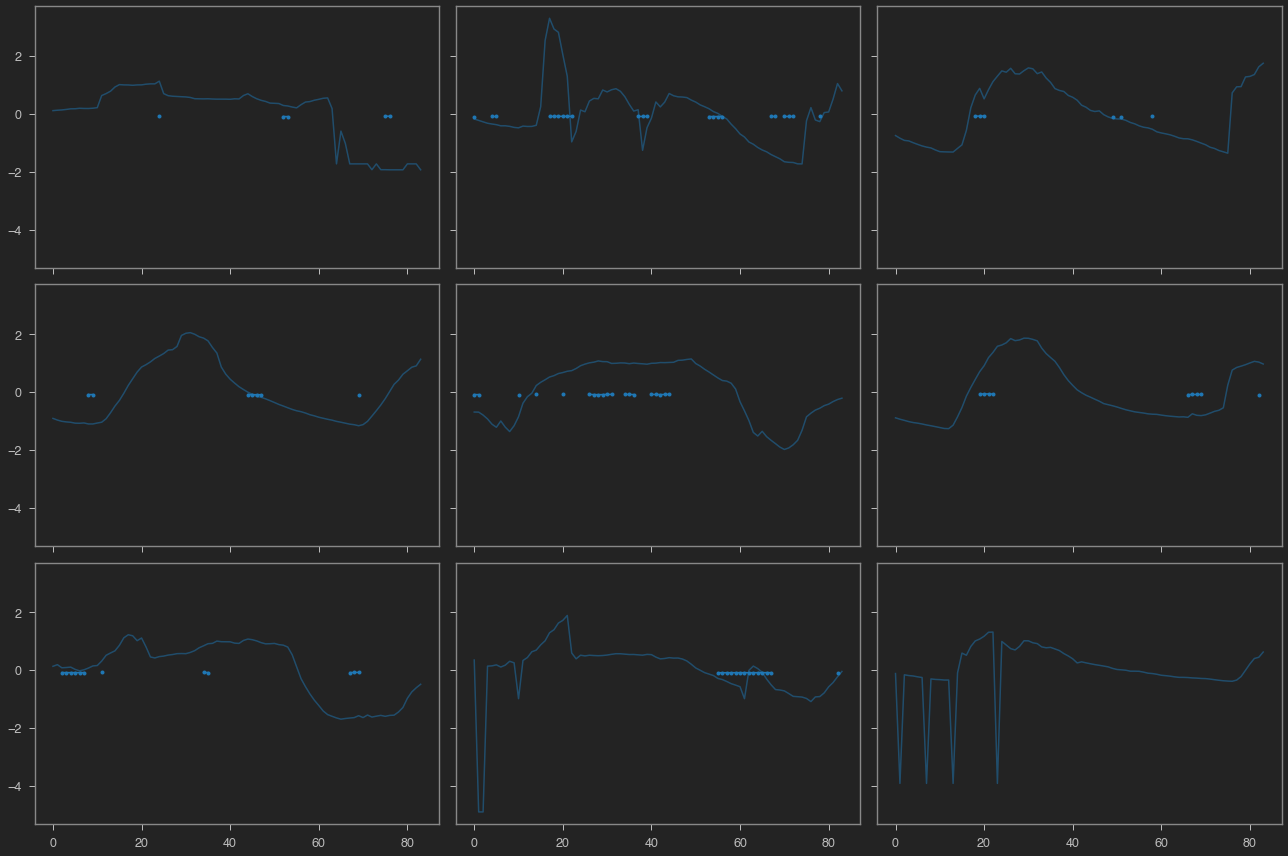

In [ ]:
learn.MVP.show_preds(sharey=True) # these preds are highly inaccurate as the model's been trained for just 1 epoch for testing purposes

In [ ]:
# Fine-tune
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
labeled_dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
learn = ts_learner(labeled_dls, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{fname}.pth', metrics=[accuracy])
learn.fine_tune(1)

weights from data/MVP/MoteStrain.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,0.692031,0.695892,0.460863,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.691414,0.693688,0.460863,00:17


In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
fname = f'{dsid}_test'
mvp = MVP(subsequence_mask=True, sync='random', variable_mask=True, future_mask=True, fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=mvp) # Metrics will not be used!

/Users/nacho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Only future_mask will be used


In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
fname = f'{dsid}_test'
mvp = MVP(subsequence_mask=True, sync='random', variable_mask=True, future_mask=True, custom_mask=partial(create_future_mask, r=.15),
                fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=mvp) # Metrics will not be used!

/Users/nacho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Only custom_mask will be used


In [ ]:
# hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.MVP.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Conve